<a href="https://colab.research.google.com/github/hphp777/GAN/blob/master/Basic/GAN1010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
- GAN을 훈련하는 방법은 다음과 같은 단계에 맞추어 훈련하는 것이다.
 (1) 실제 데이터셋을 미리 살펴본다. (2) 판별기가 적어도 실제의 데이터와 임의의 노이즈를 구별할 수 있도록 데이터를 만들어내는지 살펴본다. (3) 훈련되지 않은 생성기가 올바른 형태의 데이터를 만들어 내는지 확인한다. (4) 손실이 어떻게 변하는지 시각화 한다.
- 잘 훈련된 GAN은 생성된 가짜의 이미지와 실제 이미지를 잘 구별하지 못하는 상태이다. 즉, 출력은 0.5로서 0.0과 0.1의 중간에 해당하는 값이다. 평균 제곱 오차의 이상적인 값은 0.25이다. (판별기의 동작이 클래스를 맞추는게 아니고 진짜인지 가짜인지 구분하는것에 있으며, 따라서 실제인지 가짜인지 모호하다고 판별하는 0.5의 값이 이상적이라는 것이다)
- 생성기와 판별기를 각각 따로 시각화 하는 것은 유용하다. 생성기의 손실은 생성된 데이터로부터 발생한 판별기의 손실이다. (같은 결과를 가지고 생성기, 판별기의 가중치를 모두 업데이트 한다.) 

In [ ]:
import torch 
import torch.nn as nn

import pandas 
import numpy
import matplotlib.pyplot as plt

import random

# Discriminator

In [ ]:
def generate_real():
  real_data = torch.FloatTensor(
      [
       random.uniform(0.8, 1.0),
       random.uniform(0.0, 0.2),
       random.uniform(0.8, 1.0),
       random.uniform(0.0, 0.2),
      ]
  )
  return real_data

print(generate_real())

tensor([0.9740, 0.0745, 0.9570, 0.1039])


In [ ]:
def generate_random(size):
  random_data = torch.rand(size)
  return random_data

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    #파이토치 부모클래스 초기화
    super().__init__()

    #신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(4,3),
        nn.Sigmoid(),
        nn.Linear(3,1),
        nn.Sigmoid()
    )

    #손실함수 설정: 평균제곱 오차 함수
    self.loss_function = nn.MSELoss()

    #SGD 옵티마이저 설정 : 확률적 경사 하강법
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행 측정을 위한 변수 초기화
    # 확률적 경사하강법 
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    
    #신경망 출력 계산
    outputs = self.forward(inputs)

    #손실 계산
    loss = self.loss_function(outputs,targets)

    #카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if self.counter%10 == 0:
      self.progress.append(loss.item())
      pass
    if self.counter % 10000 == 0:
      print("counter = ", self.counter)
      pass

    #기울기를 초기화하고 역전파 후 가중치 계산
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0,0.25,0.5))
    pass

In [ ]:
D = Discriminator()

for i in range(10000):
  # 실제 데이터
  D.train(generate_real(), torch.FloatTensor([1.0]))
  # 생성된 데이터
  D.train(generate_random(4), torch.FloatTensor([0.0]))
  
  # 1010패턴 데이터는 진짜이므로 목표 출력은 1.0으로
  # 임의의 노이즈 데이터는 가짜이므로 목표 출력은 0.0으로

counter =  10000
counter =  20000


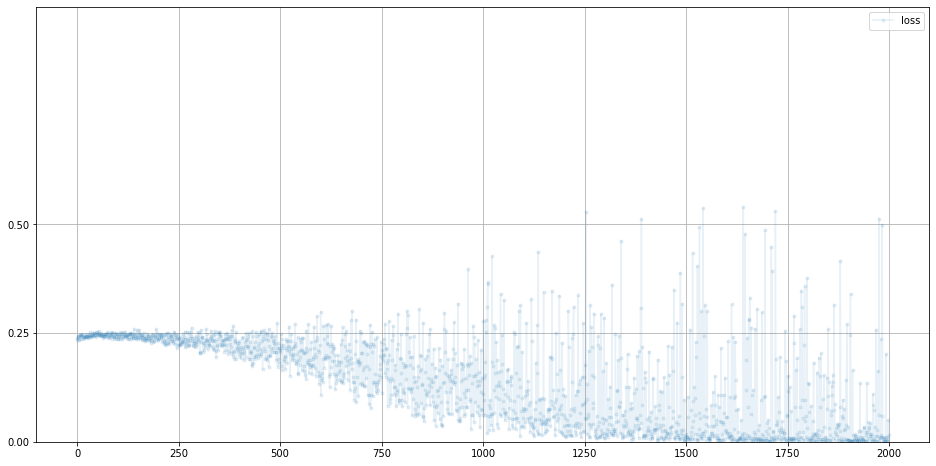

In [ ]:
# 판별기가 1010패턴에 적응하면서 성능이 나아짐에 따라 손실은 0을 향해 간다.
D.plot_progress()

In [ ]:
# 판별기가 1010데이터를 잘 판별하는것을 확인할 수 있다.
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.7761461734771729
0.33765414357185364


# Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    #파이토치 부모클래스 초기화
    super().__init__()

    #신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(1,3),
        nn.Sigmoid(),
        nn.Linear(3,4),
        nn.Sigmoid()
    )

    # 손실함수는 오직 판별기에만 적용이 되기 때문에 생성기에서는 필요가 없다.

    #SGD 옵티마이저 설정 : 확률적 경사 하강법
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행 측정을 위한 변수 초기화
    # 확률적 경사하강법 
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, D, inputs, targets):
    
    #신경망 출력 계산
    g_output = self.forward(inputs)

    #판별기로 전달
    d_output = D.forward(g_output)

    #손실 계산
    loss = D.loss_function(d_output,targets)

    #카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if self.counter%10 == 0:
      self.progress.append(loss.item())
      pass

    #기울기를 초기화하고 역전파 후 가중치 계산
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass  

In [ ]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))
# 생성기에서 만들어낸 가짜 데이터는 아직 1010이 아님. 왜냐하면 아직 훈련이 되어있지 않기 때문에

tensor([0.3932, 0.5057, 0.3503, 0.6118], grad_fn=<SigmoidBackward>)

# GAN 훈련하기

In [ ]:
%%time

D = Discriminator()
G = Generator()

image_list = []

# 판별기와 생성기 훈련

for i in range(10000):
  # 1단계: 참에 대해 판별기 훈련 
  D.train(generate_real(), torch.FloatTensor([1.0]))

  # 두개가 경쟁적으로 학습한다.

  # 2단계: 거짓에 대해 판별기 훈련
  # G의 기울기가 계산되지 않도록 detatch 함수를 이용
  # 가짜 데이터에 대해 결과가 0이 나와야 잘한것(속지 않은 것)
  D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

  # 3단계: 생성기 훈련
  # 판별기와 반대로 결과가 1이 나와야 잘한것(속인것)
  G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

  if (i % 1000 == 0):
    image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())

  pass

counter =  10000
counter =  20000
CPU times: user 10.6 s, sys: 25.1 ms, total: 10.6 s
Wall time: 10.6 s


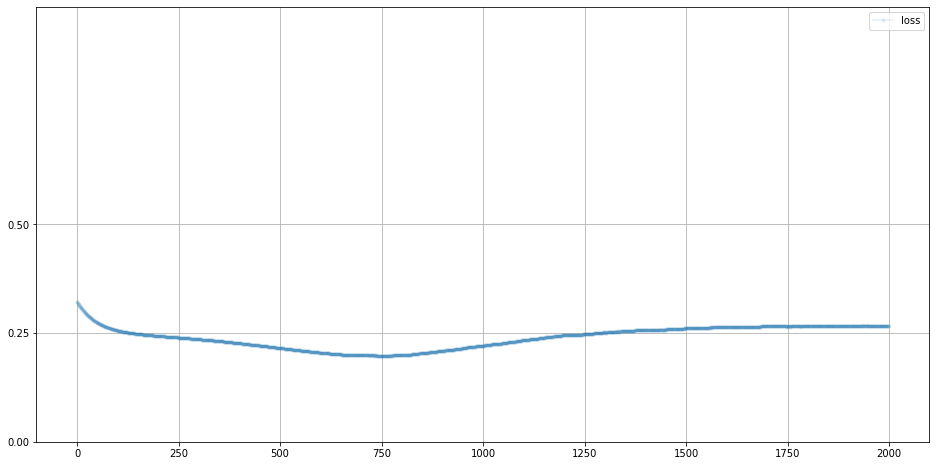

In [ ]:
# 값이 0.25에 머무른다는것은 0.5의 제곱을 나타내는데, 이는 판별기가 생성기의 데이터를 보고 0 또는 1로 확신하지 못했다는것을 의미한다.
# 이는 생성기가 가짜데이터를 잘 만들어내고있음을 의미한다.
# 진짜 데이터를 보고도 가짜라고 대답한 경우가 0.5, 가짜를 보고도 진짜라고 대답한 경우가 0.5인것
D.plot_progress()

In [ ]:
# 실제로 생성기가 만들어내는 데이터를 확인하면 잘 만들어내는것을 확인할 수 있다.
G.forward(torch.FloatTensor([0.5]))

tensor([0.9159, 0.0379, 0.9379, 0.0400], grad_fn=<SigmoidBackward>)

# 생성기가 훈련되는 과정을 시각화해서 살펴보기

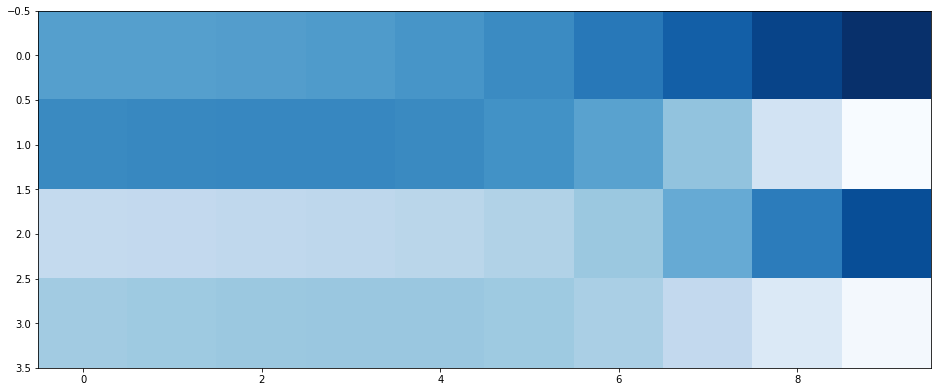

In [ ]:
# 색이 진할수록 1, 연할수록 0 
# 처음에는 그저 그렇다가 끝으로 갈수록 1010패턴이 되어가는것을 확인할 수 있다.
plt.figure(figsize=(16, 8))
plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')